In [1]:
%matplotlib notebook

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
import pyrexMD.core as core
import pyrexMD.misc as misc
import pyrexMD.analysis.analysis as ana
import pyrexMD.analysis.contacts as con
import pyrexMD.analysis.gdt as gdt
import pyrexMD.rex as rex
import pyrexMD.gmx as gmx
misc.apply_matplotlib_rc_settings()

In [2]:
### change if necessary

root = f"files/rex"
root = misc.cd(root)

ref_pdb0 = f"1lmb_Chain4.pdb"
pdbid = ana.get_PDBid(ref_pdb0)

#misc.mkdir(f"./important_files/")
score_fin = f"{pdbid.upper()}.rr"

Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex


In [3]:
u = mda.Universe(ref_pdb0)
u
tv = core.iPlayer(u)
tv()

In [4]:
# create ref (apply forcefield)
ref_pdb = f"{misc.get_filedir(ref_pdb0)}/{misc.get_base(ref_pdb0)}_ref.pdb"
ref_pdb = gmx.get_ref_structure(ref_pdb0, ref_pdb)
gmx.clean_up(misc.get_filedir(ref_pdb), verbose=False)
gmx.clean_up(verbose=False)
print()

# apply forcefield on decoys
decoy_dir = f"{root}/decoys"
decoy_dir = rex.apply_ff_best_decoys(decoy_dir) # overwrite variable
decoy_paths = [f"{decoy_dir}/{item}" for item in misc.read_file(f"{decoy_dir}/decoy_scores.log", usecols=0, skiprows=1, dtype=str)]

# assign decoys to rex_i folders
rex.assign_best_decoys(decoy_dir, verbose=False)

# copy rex_1 content to get important parameters (fixed box size, fixed number of solution molecules)
misc.cprint("\nCopied 'rex_1' content to 'rex_0_get_system_parameters' (fixed box size, fixed number of solution molecules).", "blue")
_ = misc.cp("rex_1", "rex_0_get_system_parameters", verbose=False)

Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/1lmb_Chain4_ref.pdb



  0%|          | 0/10 [00:00<?, ?it/s]

Copied source files to directories: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_<i> (i=1,...,10)

Copied 'rex_1' content to 'rex_0_get_system_parameters' (fixed box size, fixed number of solution molecules).


# RESIDUE Analysis (based on rex_1 decoy)

In [5]:
ref0 = mda.Universe(ref_pdb0)
tv = core.iPlayer(ref0)
tv()

In [6]:
ref = mda.Universe(ref_pdb)
mobile = mda.Universe(decoy_paths[0])

ana.align_resids(mobile, ref)

In [7]:
print("Mobile:")
print(mobile.residues.resids)
print(mobile.residues.resnames)

print("\nRef:")
print(ref.residues.resids)
print(ref.residues.resnames)

Mobile:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
['SER' 'THR' 'LYS' 'LYS' 'LYS' 'PRO' 'LEU' 'THR' 'GLN' 'GLU' 'GLN' 'LEU'
 'GLU' 'ASP' 'ALA' 'ARG' 'ARG' 'LEU' 'LYS' 'ALA' 'ILE' 'TYR' 'GLU' 'LYS'
 'LYS' 'LYS' 'ASN' 'GLU' 'LEU' 'GLY' 'LEU' 'SER' 'GLN' 'GLU' 'SER' 'VAL'
 'ALA' 'ASP' 'LYS' 'MET' 'GLY' 'MET' 'GLY' 'GLN' 'SER' 'GLY' 'VAL' 'GLY'
 'ALA' 'LEU' 'PHE' 'ASN' 'GLY' 'ILE' 'ASN' 'ALA' 'LEU' 'ASN' 'ALA' 'TYR'
 'ASN' 'ALA' 'ALA' 'LEU' 'LEU' 'ALA' 'LYS' 'ILE' 'LEU' 'LYS' 'VAL' 'SER'
 'VAL' 'GLU' 'GLU' 'PHE' 'SER' 'PRO' 'SER' 'ILE' 'ALA' 'ARG' 'GLU' 'ILE'
 'TYR' 'GLU' 'MET' 'TYR' 'GLU' 'ALA' 'VAL' 'SER']

Ref:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

In [8]:
# modify sel_detail if necessary ~ GDT: use CA atoms
sel1, sel2 = ana.get_matching_selection(mobile, ref, sel="protein and name CA")
misc.cprint(f"Matching selection strings:", "blue")
misc.cprint(f"Mobile:    sel1 = {sel1}", "blue")
misc.cprint(f"Reference: sel2 = {sel2}" , "blue") 

print(f"\nResids in sel1:\n{mobile.atoms.select_atoms(sel1).residues.resnames}")
print(f"Resids in sel2:\n{ref.atoms.select_atoms(sel2).residues.resnames}")

if np.all(mobile.atoms.select_atoms(sel1).residues.resnames == ref.atoms.select_atoms(sel2).residues.resnames):
    misc.cprint(f"Resids match\n", "green")
else:
     misc.cprint(f"Resids do not match\n", "red")

print("Atoms in sel1:", mobile.atoms.select_atoms(sel1).n_atoms)
print("Atoms in sel2:", ref.atoms.select_atoms(sel2).n_atoms)


print("Atoms in Mobile:", mobile.atoms.n_atoms)
print("Atoms in Reference:", ref.atoms.n_atoms)
if mobile.atoms.n_atoms == ref.atoms.n_atoms:
    misc.cprint(f"Atom counts match", "green")
else:
     misc.cprint(f"Atom counts do not match", "red")

Matching selection strings:
Mobile:    sel1 = protein and name CA and resid 1-92
Reference: sel2 = protein and name CA

Resids in sel1:
['SER' 'THR' 'LYS' 'LYS' 'LYS' 'PRO' 'LEU' 'THR' 'GLN' 'GLU' 'GLN' 'LEU'
 'GLU' 'ASP' 'ALA' 'ARG' 'ARG' 'LEU' 'LYS' 'ALA' 'ILE' 'TYR' 'GLU' 'LYS'
 'LYS' 'LYS' 'ASN' 'GLU' 'LEU' 'GLY' 'LEU' 'SER' 'GLN' 'GLU' 'SER' 'VAL'
 'ALA' 'ASP' 'LYS' 'MET' 'GLY' 'MET' 'GLY' 'GLN' 'SER' 'GLY' 'VAL' 'GLY'
 'ALA' 'LEU' 'PHE' 'ASN' 'GLY' 'ILE' 'ASN' 'ALA' 'LEU' 'ASN' 'ALA' 'TYR'
 'ASN' 'ALA' 'ALA' 'LEU' 'LEU' 'ALA' 'LYS' 'ILE' 'LEU' 'LYS' 'VAL' 'SER'
 'VAL' 'GLU' 'GLU' 'PHE' 'SER' 'PRO' 'SER' 'ILE' 'ALA' 'ARG' 'GLU' 'ILE'
 'TYR' 'GLU' 'MET' 'TYR' 'GLU' 'ALA' 'VAL' 'SER']
Resids in sel2:
['SER' 'THR' 'LYS' 'LYS' 'LYS' 'PRO' 'LEU' 'THR' 'GLN' 'GLU' 'GLN' 'LEU'
 'GLU' 'ASP' 'ALA' 'ARG' 'ARG' 'LEU' 'LYS' 'ALA' 'ILE' 'TYR' 'GLU' 'LYS'
 'LYS' 'LYS' 'ASN' 'GLU' 'LEU' 'GLY' 'LEU' 'SER' 'GLN' 'GLU' 'SER' 'VAL'
 'ALA' 'ASP' 'LYS' 'MET' 'GLY' 'MET' 'GLY' 'GLN' 'SER' 'GLY' 'VAL' '

# TPR Analysis

<IPython.core.display.Javascript object>


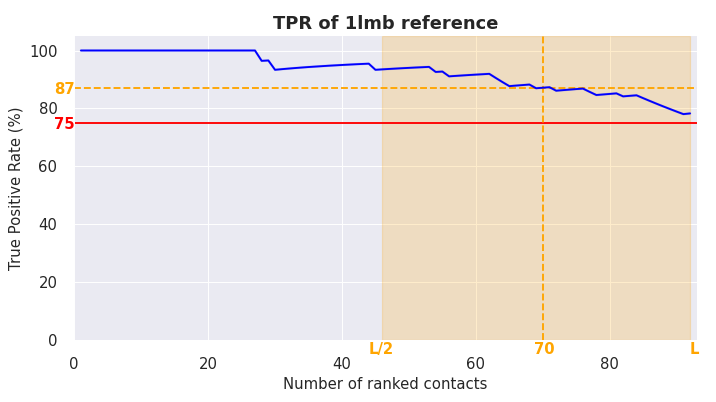

Reference has 92 residues


In [9]:
score_fin = f"{pdbid.upper()}.rr"
_ = con.plot_DCA_TPR(ref, score_fin,
                     n_DCA=len(ref.residues), DCA_cols=(0,1),
                     pdbid=f"{pdbid} reference")
misc.cprint(f"Reference has {len(ref.residues)} residues", "blue")

<IPython.core.display.Javascript object>


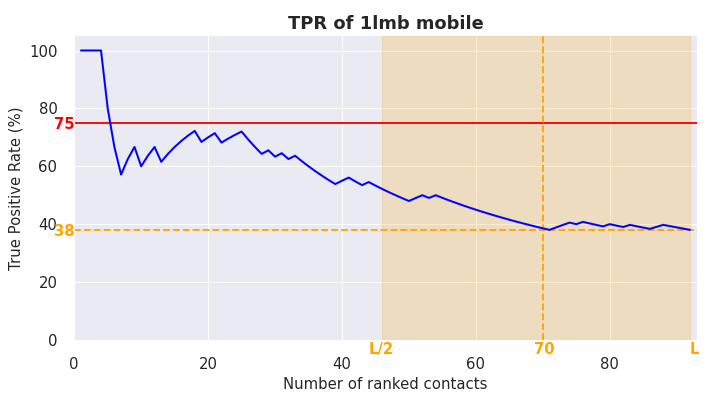

Mobile has 92 residues


In [10]:
# just a quick comparison with a decoy to see how different the structures are
score_fin = f"{pdbid.upper()}.rr"
_ = con.plot_DCA_TPR(mobile, score_fin,
                     n_DCA=len(ref.residues), DCA_cols=(0,1),
                     pdbid=f"{pdbid} mobile")
misc.cprint(f"Mobile has {len(ref.residues)} residues", "blue")

In [11]:
GDT_percent, _, _, RMSD, _ = gdt.GDT(mobile, ref, sel1=sel1, sel2=sel2, disable=True)
print(f"RMSD:   {round(RMSD[0][1], 3)} A")
print(f"GDT_TS: {round(gdt.get_GDT_TS(GDT_percent)[0], 3)}")
print(f"GDT_HA: {round(gdt.get_GDT_HA(GDT_percent)[0], 3)}")

RMSD:   17.416 A
GDT_TS: 0.542
GDT_HA: 0.0


## Test if all REX pdbs have equal RES, ATOM, NAME arrays

In [12]:
pdb_is_known = True


REX_DIRS = rex.get_REX_DIRS("./", realpath=True)
REX_PDBS = rex.get_REX_PDBS("./", realpath=True)

if pdb_is_known:  
    # Test REX PDBS for equal arrays with known ref pdb
    misc.cprint("Using known PDB as reference...", "blue")
    rex.test_REX_PDBS(REX_PDBS, ref_pdb)
else:
    misc.cprint("PDB is unknown. Using first REX PDB as reference...", "red")
    rex.test_REX_PDBS(REX_PDBS, REX_PDBS[0])

Using known PDB as reference...
All tested PDBs have equal RES, ATOM, NAME arrays.


In [13]:
# RUN THIS IF CELL ABOVE GIVES ERROR: "Parsed arrays of <...> do not match with <...>""
# check for unequal parsed arrays (modify x1 and x2 input pdb_files if necessary)
check = True

if check:
    misc.cprint(f"ref pdb: {ref_pdb}", "blue")
    for test_pdb in REX_PDBS:
        x1 = mda.Universe(ref_pdb)
        x2 = mda.Universe(test_pdb)
        print("###########################################################################################")
        if np.all(x1.residues.resnames == x2.residues.resnames) == False:
            misc.cprint(f"RES  NAMES are not equal ({test_pdb}):", "red")
            print(x1.residues.resnames == x2.residues.resnames)
        else:
            misc.cprint(f"RES  NAMES are equal ({test_pdb}).", "green")
        if np.all(x1.atoms.names == x2.atoms.names) == False:
            misc.cprint(f"ATOM NAMES are not equal ({test_pdb}):", "red")
            for i in range(len(x1.atoms.names)):
                if x1.atoms.names[i] != x2.atoms.names[i]:
                    misc.cprint(f"resid1: {x1.atoms.resids[i]}    resid2: {x2.atoms.resids[i]} || atom-id1: {x1.atoms.ids[i]}    atom-id2: {x2.atoms.ids[i]} || atom-name1:{x1.atoms.names[i]}    atom-name2:{x2.atoms.names[i]}")
        else:
            misc.cprint(f"ATOM NAMES are equal ({test_pdb}).", "green")

ref pdb: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/1lmb_Chain4_ref.pdb
###########################################################################################
RES  NAMES are equal (/home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1/1LMB_16_ref.pdb).
ATOM NAMES are equal (/home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1/1LMB_16_ref.pdb).
###########################################################################################
RES  NAMES are equal (/home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2/1LMB_23_ref.pdb).
ATOM NAMES are equal (/home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2/1LMB_23_ref.pdb).
###########################################################################################
RES  NAMES are equal (/home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_3/1LMB_45_r

# WF: get system parameters
required parameter for REX setup with different start configurations:
- fixed box dimension
- fixed number of solution molecules

In [14]:
misc.cd(f"{root}/rex_0_get_system_parameters")
decoy_pdb = misc.get_filename("*_ref.pdb")

Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters


In [15]:
# 1) generate topology
protein_gro = gmx.pdb2gmx(f=decoy_pdb, verbose=False)

Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/protein.gro
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/logs/pdb2gmx_2.log


In [16]:
# 2) generate box 
# unfolded proteins: d=1
# folded proteins:   d=2,..,d=3
box_gro = gmx.editconf(f=protein_gro, o="box.gro", bt="cubic", d=2, verbose=False)

Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/box.gro
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/logs/editconf_2.log


In [17]:
boxsize = rex.WF_getParameter_boxsize("./logs/editconf_1.log")
boxsize

Reading logfile: ./logs/editconf_1.log
    system size :  3.681  4.557  4.142 (nm)
    diameter    :  5.398               (nm)
    box volume  :  69.46               (nm^3)
new box vectors :  9.398  9.398  9.398 (nm)
new box volume  : 830.16               (nm^3)
suggested box size: 9.4

9.4

In [18]:
# Apply fixed boxsize
box_gro = gmx.editconf(f=protein_gro, o="box.gro", bt="cubic", box=boxsize, c=True, verbose=False)
print()

if boxsize == rex.WF_getParameter_boxsize("./logs/editconf_1.log", verbose=True):
    misc.cprint(f"\n\nSuccess: new box vectors have fixed size: {boxsize}", "green")
else:
    misc.cprint(f"\n\nCheck above if new box vectors have fixed size: {boxsize}", "red")

Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/box.gro
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/logs/editconf_3.log

Reading logfile: ./logs/editconf_1.log
    system size :  3.681  4.557  4.142 (nm)
    diameter    :  5.398               (nm)
    box volume  :  69.46               (nm^3)
new box vectors :  9.398  9.398  9.398 (nm)
new box volume  : 830.16               (nm^3)
suggested box size: 9.4

Success: new box vectors have fixed size: 9.4


In [19]:
# 3) generate solvent
solvent_gro = gmx.solvate(cp=box_gro, verbose=False)

Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/solvent.gro
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_0_get_system_parameters/logs/solvate_2.log


In [20]:
maxsol = rex.WF_getParameter_maxsol("./logs/solvate_1.log")
maxsol

Reading logfile: ./logs/solvate_1.log
Number of solvent molecules:  26092   
suggested max solution: 26042

26042

# populate replicas with decoys

In [21]:
# modify values (copy&paste from above)
boxsize_manual = 9.4
maxsol_manual = 26042

# TEST if values are updated
if "boxsize" in locals():
    if boxsize != boxsize_manual:
        misc.cprint("boxsize_manual is not updated. copy&paste value from above...", "red")
else:
    boxsize = boxsize_manual
    
if "maxsol" in locals():
    if maxsol != maxsol_manual:
        misc.cprint("maxsol_manual is not updated. copy&paste value from above...", "red")
else:
    maxsol = maxsol_manual

In [22]:
# change dir back to root
misc.cd(root)    
rex_dirs = rex.get_REX_DIRS()

Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex


In [23]:
rex.WF_REX_setup(rex_dirs=rex_dirs, boxsize=boxsize, maxsol=maxsol, verbose=False, verbose_gmx=False)

#######################################################################################
Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1
Using decoy pdb: 1LMB_16_ref.pdb

Generating topology...
Generating box with fixed size (9.4) ...
Generating solvent with fixed solvent molecules (26042)...
Generating ions...
#######################################################################################
Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2
Using decoy pdb: 1LMB_23_ref.pdb

Generating topology...
Generating box with fixed size (9.4) ...
Generating solvent with fixed solvent molecules (26042)...
Generating ions...
#######################################################################################
Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_3
Using decoy pdb: 1LMB_45_ref.pdb

Generating topology...
Genera

In [24]:
# limited number of steps to 10 for this example
rex.WF_REX_setup_energy_minimization(rex_dirs=rex_dirs, nsteps=10, verbose=False)

#######################################################################################
Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1
Performing energy minimization...
#######################################################################################
Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2
Performing energy minimization...
#######################################################################################
Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_3
Performing energy minimization...
#######################################################################################
Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_4
Performing energy minimization...
####################################################################################

# Modify Topology:
use rex_1 as template for all replica
(different start configurations but fixed boxsize and fixed number of solution molecules)

In [25]:
n_DCA = 70   # check TPR Analysis plot for ideal number
misc.cd(root)

RES_PAIR, ATOM_PAIR = rex.DCAREX_res2atom_mapping(ref_pdb=ref_pdb, DCA_fin=score_fin, n_DCA=n_DCA, usecols=(0,1), default_dir="./important_files")
misc.cprint("\nRES PAIR    ATOM PAIR", "blue")
_ = misc.print_table([RES_PAIR, ATOM_PAIR], spacing=12)

Changed directory to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex
ATTENTION: Make sure that ref_pdb is the reference PDB taken after applying a forcefield, since added hyrogen atoms will shift the atom numbers.

Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/important_files/1LMB_DCA_used.txt

RES PAIR    ATOM PAIR
(37, 47)    (612, 739)
(36, 47)    (596, 739)
(33, 47)    (553, 739)
(37, 44)    (612, 704)
(18, 50)    (296, 772)
(19, 51)    (315, 791)
(39, 68)    (634, 1043)
(34, 44)    (570, 704)
(40, 68)    (656, 1043)
(15, 50)    (238, 772)
(37, 43)    (612, 697)
(66, 73)    (1011, 1130)
(15, 53)    (238, 825)
(40, 65)    (656, 992)
(50, 57)    (772, 875)
(33, 44)    (553, 704)
(40, 64)    (656, 973)
(49, 55)    (762, 851)
(25, 69)    (424, 1062)
(66, 72)    (1011, 1119)
(66, 76)    (1011, 1176)
(15, 51)    (238, 791)
(62, 73)    (953, 1130)
(33, 48)    (553, 755)
(63, 73)    (963, 1130)
(18, 51)    (296,

In [26]:
rex_dirs = rex.get_REX_DIRS()

for ndx, rex_dir in enumerate(rex_dirs, start=1):
    rex.DCAREX_modify_topology(top_fin=f"{misc.relpath(rex_dir)}/topol.top", 
                               DCA_used_fin=f"important_files/{pdbid.upper()}_DCA_used.txt",
                               force_k=10, 
                               save_as=f"{misc.relpath(rex_dir)}/topol_mod.top")
    
    if ndx == 1:
        misc.cp(f"{misc.relpath(rex_dir)}/topol_mod.top", "./important_files/")

Saved modified topology as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1/topol_mod.top
Copied source file to: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/important_files
Saved modified topology as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2/topol_mod.top
Saved modified topology as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_3/topol_mod.top
Saved modified topology as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_4/topol_mod.top
Saved modified topology as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_5/topol_mod.top
Saved modified topology as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_6/topol_mod.top
Saved modified topology as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_7/topol_m

# prep REX run files (temps, mdp, tpr)

In [27]:
rex_dirs = rex.get_REX_DIRS()
rex.prep_REX_temps(T_0=280, n_REX=len(rex_dirs), k=0.006)

Enter starting temperature T_0 (Kelvin):  280
Enter replica number n_REX:  10
Enter scaling factor k:  0.006

Method 1:
REX Temperature Distribution: T_i = T_0*exp(k*i)
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_temps.log

Method 2
REX Temperature Distribution:
T_0 = 280 K ; DELTA = T_0 * (exp(k*i)-exp(k*(i-1)))
T_i = T_(i-1) + a_i * DELTA
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_temps.log

Temperatures Method 1:
['280.00', '281.69', '283.38', '285.09', '286.80', '288.53', '290.26', '292.01', '293.77', '295.54']

Temperatures Method 2:
['280.00', '281.69', '283.38', '285.09', '286.80', '288.53', '290.26', '292.01', '293.77', '295.54']

Delta Temps Method 1 (DTM1):
['1.69', '1.69', '1.71', '1.71', '1.73', '1.73', '1.75', '1.76', '1.77']

Delta Temps Method 2 (DTM2):
['1.69', '1.69', '1.71', '1.71', '1.73', '1.73', '1.75', '1.76', '1.77']

Delta_Delta (DTM2-DTM1):
['0.00', '0.00'

In [28]:
rex.prep_REX_mdp(main_dir="./", n_REX=len(rex_dirs))

Enter n_REX: 10
Using rex.mdp as template and changing temperatures according to rex_temps.log...
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1/rex.mdp
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2/rex.mdp
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_3/rex.mdp
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_4/rex.mdp
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_5/rex.mdp
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_6/rex.mdp
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_7/rex.mdp
Saved mdp file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_8/rex.mdp
Saved 

In [29]:
rex.prep_REX_tpr(main_dir="./", n_REX=len(rex_dirs))

Enter n_REX: 10
preparing rex.tpr for 10 replica.
#######################################################################################
Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1/rex.tpr
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_1/logs/grompp_6.log
#######################################################################################
Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2/rex.tpr
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_2/logs/grompp_6.log
#######################################################################################
Saved file as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_3/rex.tpr
Saved log as: /home/arthur/Dropbox/#PhD/#my_scripts/myPKG/pyrexMD/pyrexMD/examples/files/rex/rex_3/logs/grompp_6.log
###########

In [ ]:
# upload files on HPC and execute production run